In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
sns.set_style('darkgrid')
sns.set_context('talk')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [2]:
# Returns (2, N) floats drawn from a 2D uncorrelated Gaussian
# with mean=(0.0, 0.0) , var=(1.0, 1.0)
def get_N_gaussian_samples(N=20, mu=0.0, var=1.0):
    return np.random.normal(loc=mu, scale=np.sqrt(var), size=(2, N))


# Returns the Pearson product-moment correlation coefficient
# assuming (2, N) structured sample array
def get_r(sample_array):
    numerator = np.sum((sample_array[0, :]
                        - np.mean(sample_array[0, :]))
                       *(sample_array[1, :]
                         - np.mean(sample_array[1, :])))
    denominator = np.sqrt(np.sum((sample_array[0, :]
                                  - np.mean(sample_array[0, :]))**2.0)
                          *np.sum((sample_array[1, :]
                                   - np.mean(sample_array[1, :]))**2.0))
    return numerator/denominator


# Calculate r for M samples of shape (2, N)
def do_M_r_samples(M, N=20, mu=0.0, var=1.0):
    return np.array([get_r(get_N_gaussian_samples(N, mu, var))
                     for i in range(0, M)])

In [3]:
def do_part_a(M=100000, N=20, mu=0.0, var=1.0, test_loc=0.975):
    r_array = do_M_r_samples(M, N, mu, var)
    sorted_r = np.sort(r_array)
    r_prob, prob_arr = np.unique(sorted_r, return_index=True) # Get CDF
    prob_arr = prob_arr/np.max(prob_arr)
    test_r = r_prob[np.where(prob_arr >= test_loc)][0] #Find where F(r) crosses test_loc

    plt.hist(r_array, color='cornflowerblue', bins='auto')
    plt.xlabel(r'$r$')
    plt.suptitle(r'Histogram of $r$')
    plt.show()
    plt.clf()

    plt.plot(r_prob, prob_arr, label=r'$F(r)$',
             linestyle='-', color='cornflowerblue')
    plt.axhline(test_loc, label=r'$F(r) =$' + str(test_loc),
                linestyle=':', color='k')
    plt.axvline(test_r, label=r'$r = $' + str(test_r),
                linestyle='--', color='k')
    plt.legend(bbox_to_anchor=(1.05, 1.0))
    plt.ylabel(r'$F(r)$')
    plt.xlabel(r'$r$')
    plt.suptitle(r'Cumulative Distribution Function of $r$')
    plt.show()
    
    print('The value of r for which F(r)=0.975 is: ', test_r)
    return r_array

In [4]:
def get_data(fname='hw5.dat'):
    return pd.read_csv(fname, delim_whitespace=True, names=['x', 'y'])


def do_part_b(r_array, alpha_param=0.95):
    hw_dat = get_data()
    data_arr = np.empty((2, 20))
    data_arr[0, :] = np.array(hw_dat['x'])
    data_arr[1, :] = np.array(hw_dat['y'])
    r_data = get_r(data_arr)

    # Estimate PDF using Scipy Kernel Density Estimation
    # KDE smooths data over a window to estimate the PDF
    r_pdf = gaussian_kde(r_array) 

    x_axis = np.linspace(np.min(r_array), np.max(r_array), 5000)
    y_axis = r_pdf.pdf(x_axis)
    max_loc = np.argmin(np.abs(x_axis))
    integral_values = np.array([r_pdf.integrate_box(x_axis[max_loc - i],
                                                    -x_axis[max_loc - i])
                                for i in range(0, int(len(x_axis)/5))])
    r_bound = np.argmin(np.abs(integral_values - alpha_param))
    r_low = x_axis[r_bound]
    r_diff = x_axis[np.argmin(np.abs(x_axis))] - r_low
    r_high = r_low + 2.0*r_diff

    plt.plot(x_axis, y_axis,
             linestyle='-', color='cornflowerblue', label=r'$P(r)$')
    plt.axvline(r_data, label=r'$r$ of data', color='k')
    plt.axvspan(r_low, r_high, color='g',
                alpha=0.3,
                label=r'Within $\alpha$ = ' + str(alpha_param*100) + r'$\%$ confidence')
    plt.legend(bbox_to_anchor=(1.05, 0.5))
    plt.ylabel(r'PDF$(r)$')
    plt.xlabel(r'$r$')
    plt.suptitle(r'Null Hypothesis Cannot Be Rejected with 95$\%$ Confidence')
    plt.show()
    return r_low, r_high, x_axis, y_axis, r_pdf

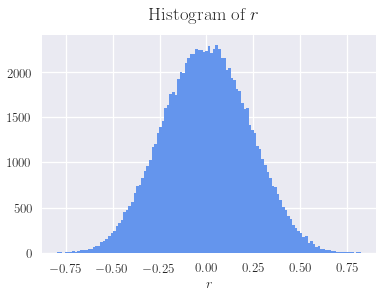

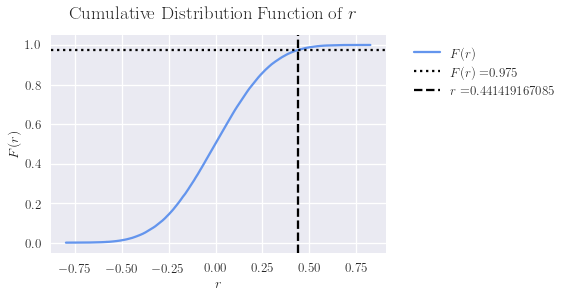

The value of r for which F(r)=0.975 is:  0.441419167085


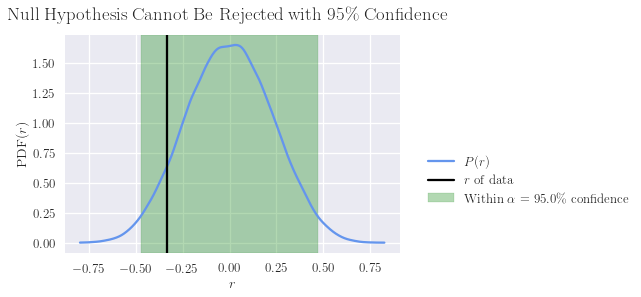

In [5]:
r_array = do_part_a()
r_low, r_high, x_axis, y_axis, r_pdf = do_part_b(r_array)